In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Model Definition

In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim, depth, residual=False, bias=True):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_dim = hidden_dim
        self.depth = depth
        self.residual = residual
        self.bias = bias
        
        self.layers = nn.ModuleList([nn.Linear(in_channels, hidden_dim, bias=self.bias)])
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=self.bias))
        self.layers.append(nn.Linear(hidden_dim, out_channels, bias=self.bias))
        
        self.activation = lambda x: torch.tanh(x)
        
    def forward(self, x):
        
        x = self.layers[0](x)
        
        for layer in self.layers[1:-1]:
            x_tmp = layer(x)
            x_tmp = self.activation(x_tmp)
            x = x + x_tmp if self.residual else x_tmp
                
        x = self.layers[-1](x)
        
        return x
        

In [3]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim, depth, residual=False, bias=True):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.hidden_dim = hidden_dim
        self.depth = depth
        self.residual = residual
        self.bias = bias
        
        self.layers = nn.ModuleList([nn.Linear(in_channels, hidden_dim, bias=self.bias)])
        for _ in range(depth - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim, bias=self.bias))
        self.layers.append(nn.Linear(hidden_dim, out_channels, bias=self.bias))
        
        self.activation = lambda x: torch.tanh(x)
        
    def forward(self, x):
        
        x = self.layers[0](x)
        
        for layer in self.layers[1:-1]:
            x_tmp = layer(x)
            x_tmp = self.activation(x_tmp)
            x = x + x_tmp if self.residual else x_tmp
                
        x = self.layers[-1](x)
        
        return x

In [4]:
from tqdm import trange
import torch.nn.init as init

def train_autoencoder(Encoder, Decoder, X, iter):
    
    in_channels = X.shape[1]
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
    
    I_minus_W = nn.Parameter(torch.Tensor(size=(in_channels, in_channels)))
    init.normal_(I_minus_W)
    I_minus_W_inv = I_minus_W.inverse()
    
    optimizer_W = torch.optim.Adam(params=[I_minus_W])
    optimizer_en = torch.optim.Adam(params=Encoder.parameters())
    optimizer_de = torch.optim.Adam(params=Decoder.parameters())
    
    Encoder = Encoder.to(device)
    Decoder = Decoder.to(device)
    I_minus_W = I_minus_W.to(device)
    X = X.to(device)
    
    loss_hist = []
    
    for it in trange(iter):
        optimizer_W.zero_grad()
        optimizer_en.zero_grad()
        optimizer_de.zero_grad()
        I_minus_W_inv = I_minus_W.inverse()
        
        X_prime = torch.matmul(X, I_minus_W.T)
        X_prime = Encoder(X_prime)
        X_prime = Decoder(X_prime)
        X_prime = torch.matmul(X_prime, I_minus_W_inv.T)
        
        # print(X.shape)
        # print(X_prime.shape)
        
        loss = torch.norm((X - X_prime), p=2, dim=1).mean()
        loss.backward()
        loss_hist.append(loss.item())
        
        optimizer_W.step()
        optimizer_en.step()
        optimizer_de.step()
        
    return Encoder, Decoder, I_minus_W, loss_hist

# Training Autoencoder

In [5]:
import wot
import numpy as np

FULL_DS_PATH = 'data/ExprMatrix.h5ad'
adata = wot.io.read_dataset(FULL_DS_PATH)
pcadata = np.load('adata_dim_400.npy')

In [6]:
import random

# pcatensor = torch.Tensor(pcadata)
atensor = torch.Tensor(adata.X.toarray())

In [7]:
sample_size = 16384
random.shuffle(atensor)
atensor_sampled = atensor[:sample_size]

In [8]:
Encoder_pca = Encoder(in_channels=19089, out_channels=400, hidden_dim=512, depth=3, residual=True, bias=True)
Decoder_pca = Decoder(in_channels=400, out_channels=19089, hidden_dim=512, depth=3, residual=True, bias=True)
Encoder_pca, Decoder_pca, I_minus_W, loss_hist = train_autoencoder(Encoder=Encoder_pca, Decoder=Decoder_pca, X=atensor_sampled, iter=100)

100%|██████████| 100/100 [12:44<00:00,  7.65s/it]


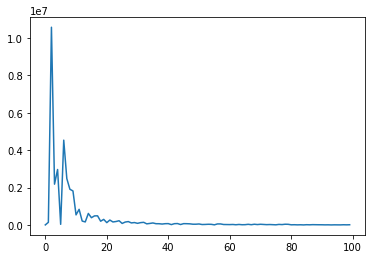

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_hist)

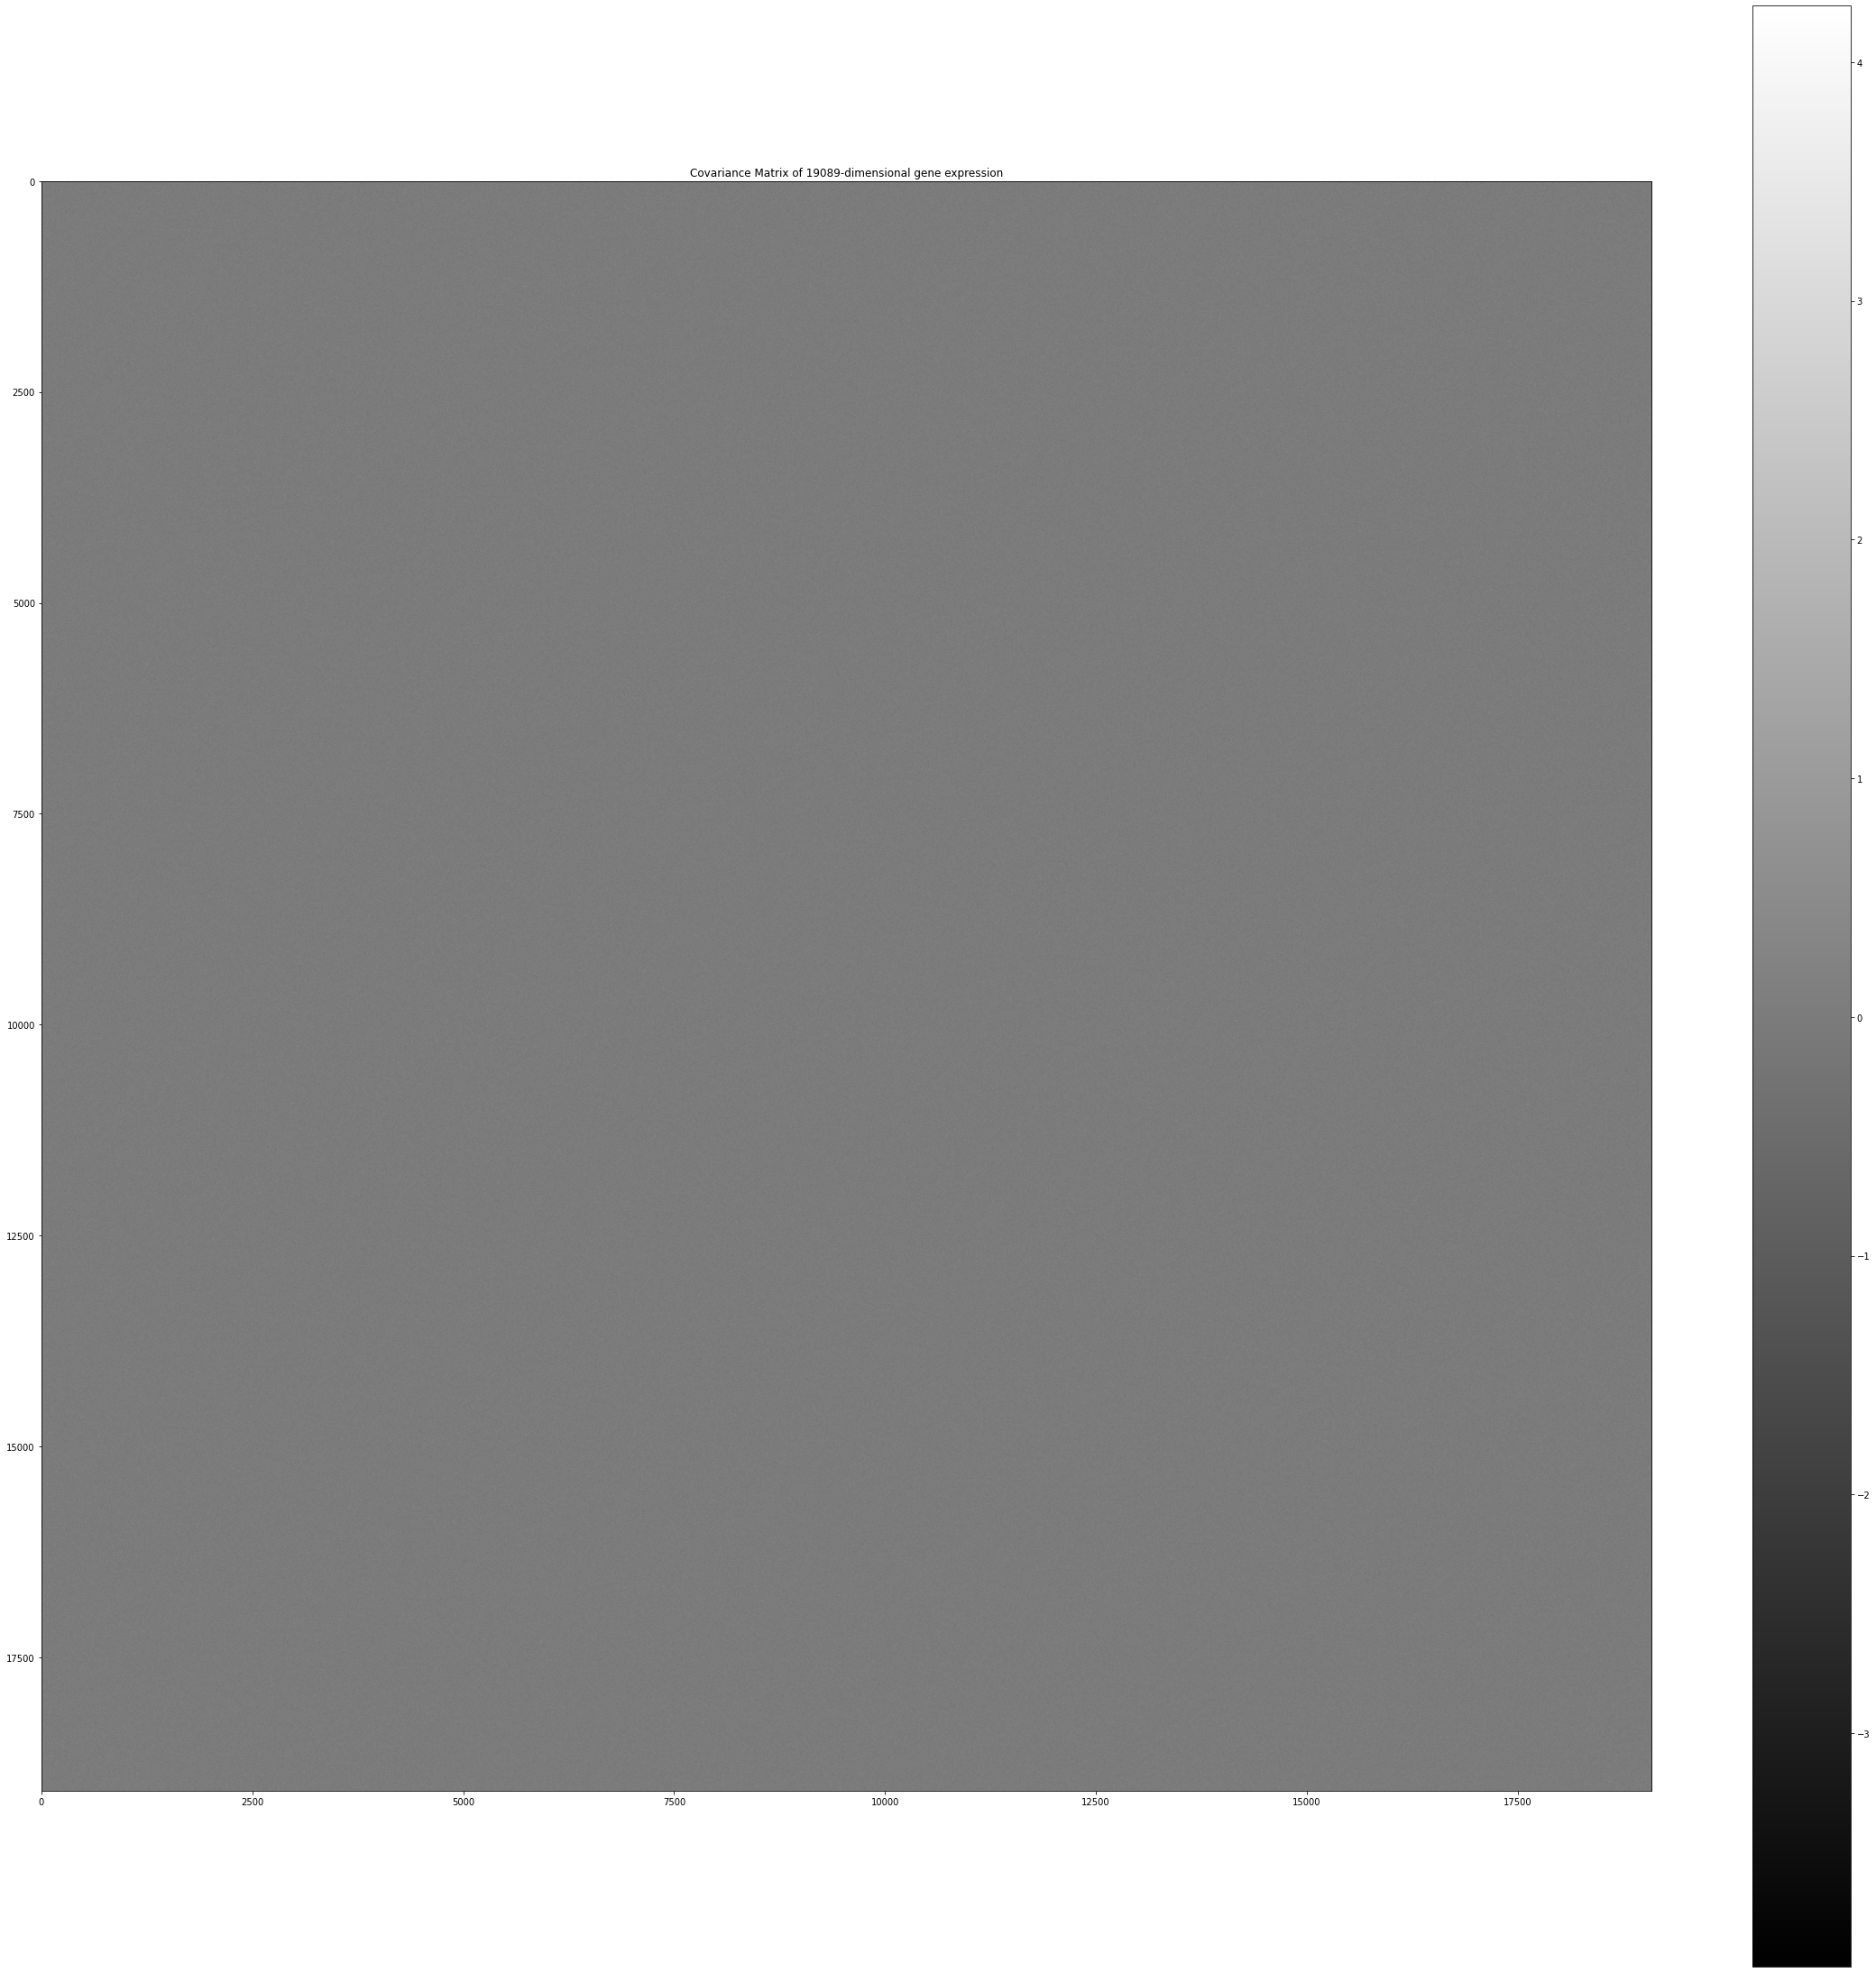

In [25]:
tmp = I_minus_W.cpu().detach().numpy()
plt.figure(figsize=(40, 40))
plt.title("Covariance Matrix of 19089-dimensional gene expression")
plt.imshow(((tmp + tmp.T) / 2), cmap='gray')
plt.colorbar()
plt.show()

In [14]:
(tmp + tmp.T) / 2

array([[-2.9413426 , -0.92810035, -0.2634869 , ...,  0.46065295,
        -0.6126158 , -0.37290677],
       [-0.92810035,  2.2094393 , -0.1619376 , ...,  0.52705085,
        -0.15598477,  0.01511074],
       [-0.2634869 , -0.1619376 ,  0.17676492, ...,  0.6259035 ,
        -0.22428328, -0.67772347],
       ...,
       [ 0.46065295,  0.52705085,  0.6259035 , ..., -1.9855745 ,
         0.17207825,  0.57069933],
       [-0.6126158 , -0.15598477, -0.22428328, ...,  0.17207825,
         2.0091717 ,  0.1974526 ],
       [-0.37290677,  0.01511074, -0.67772347, ...,  0.57069933,
         0.1974526 , -0.21386267]], dtype=float32)

# Train with PCA Data

In [16]:
pcatensor = torch.Tensor(pcadata)

Encoder_pca400 = Encoder(in_channels=400, out_channels=64, hidden_dim=256, depth=3, residual=True, bias=True)
Decoder_pca400 = Decoder(in_channels=64, out_channels=400, hidden_dim=256, depth=3, residual=True, bias=True)
Encoder_pca400, Decoder_pca400, I_minus_W_400, loss_hist_400 = train_autoencoder(Encoder=Encoder_pca400, Decoder=Decoder_pca400, X=pcatensor, iter=100)

100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


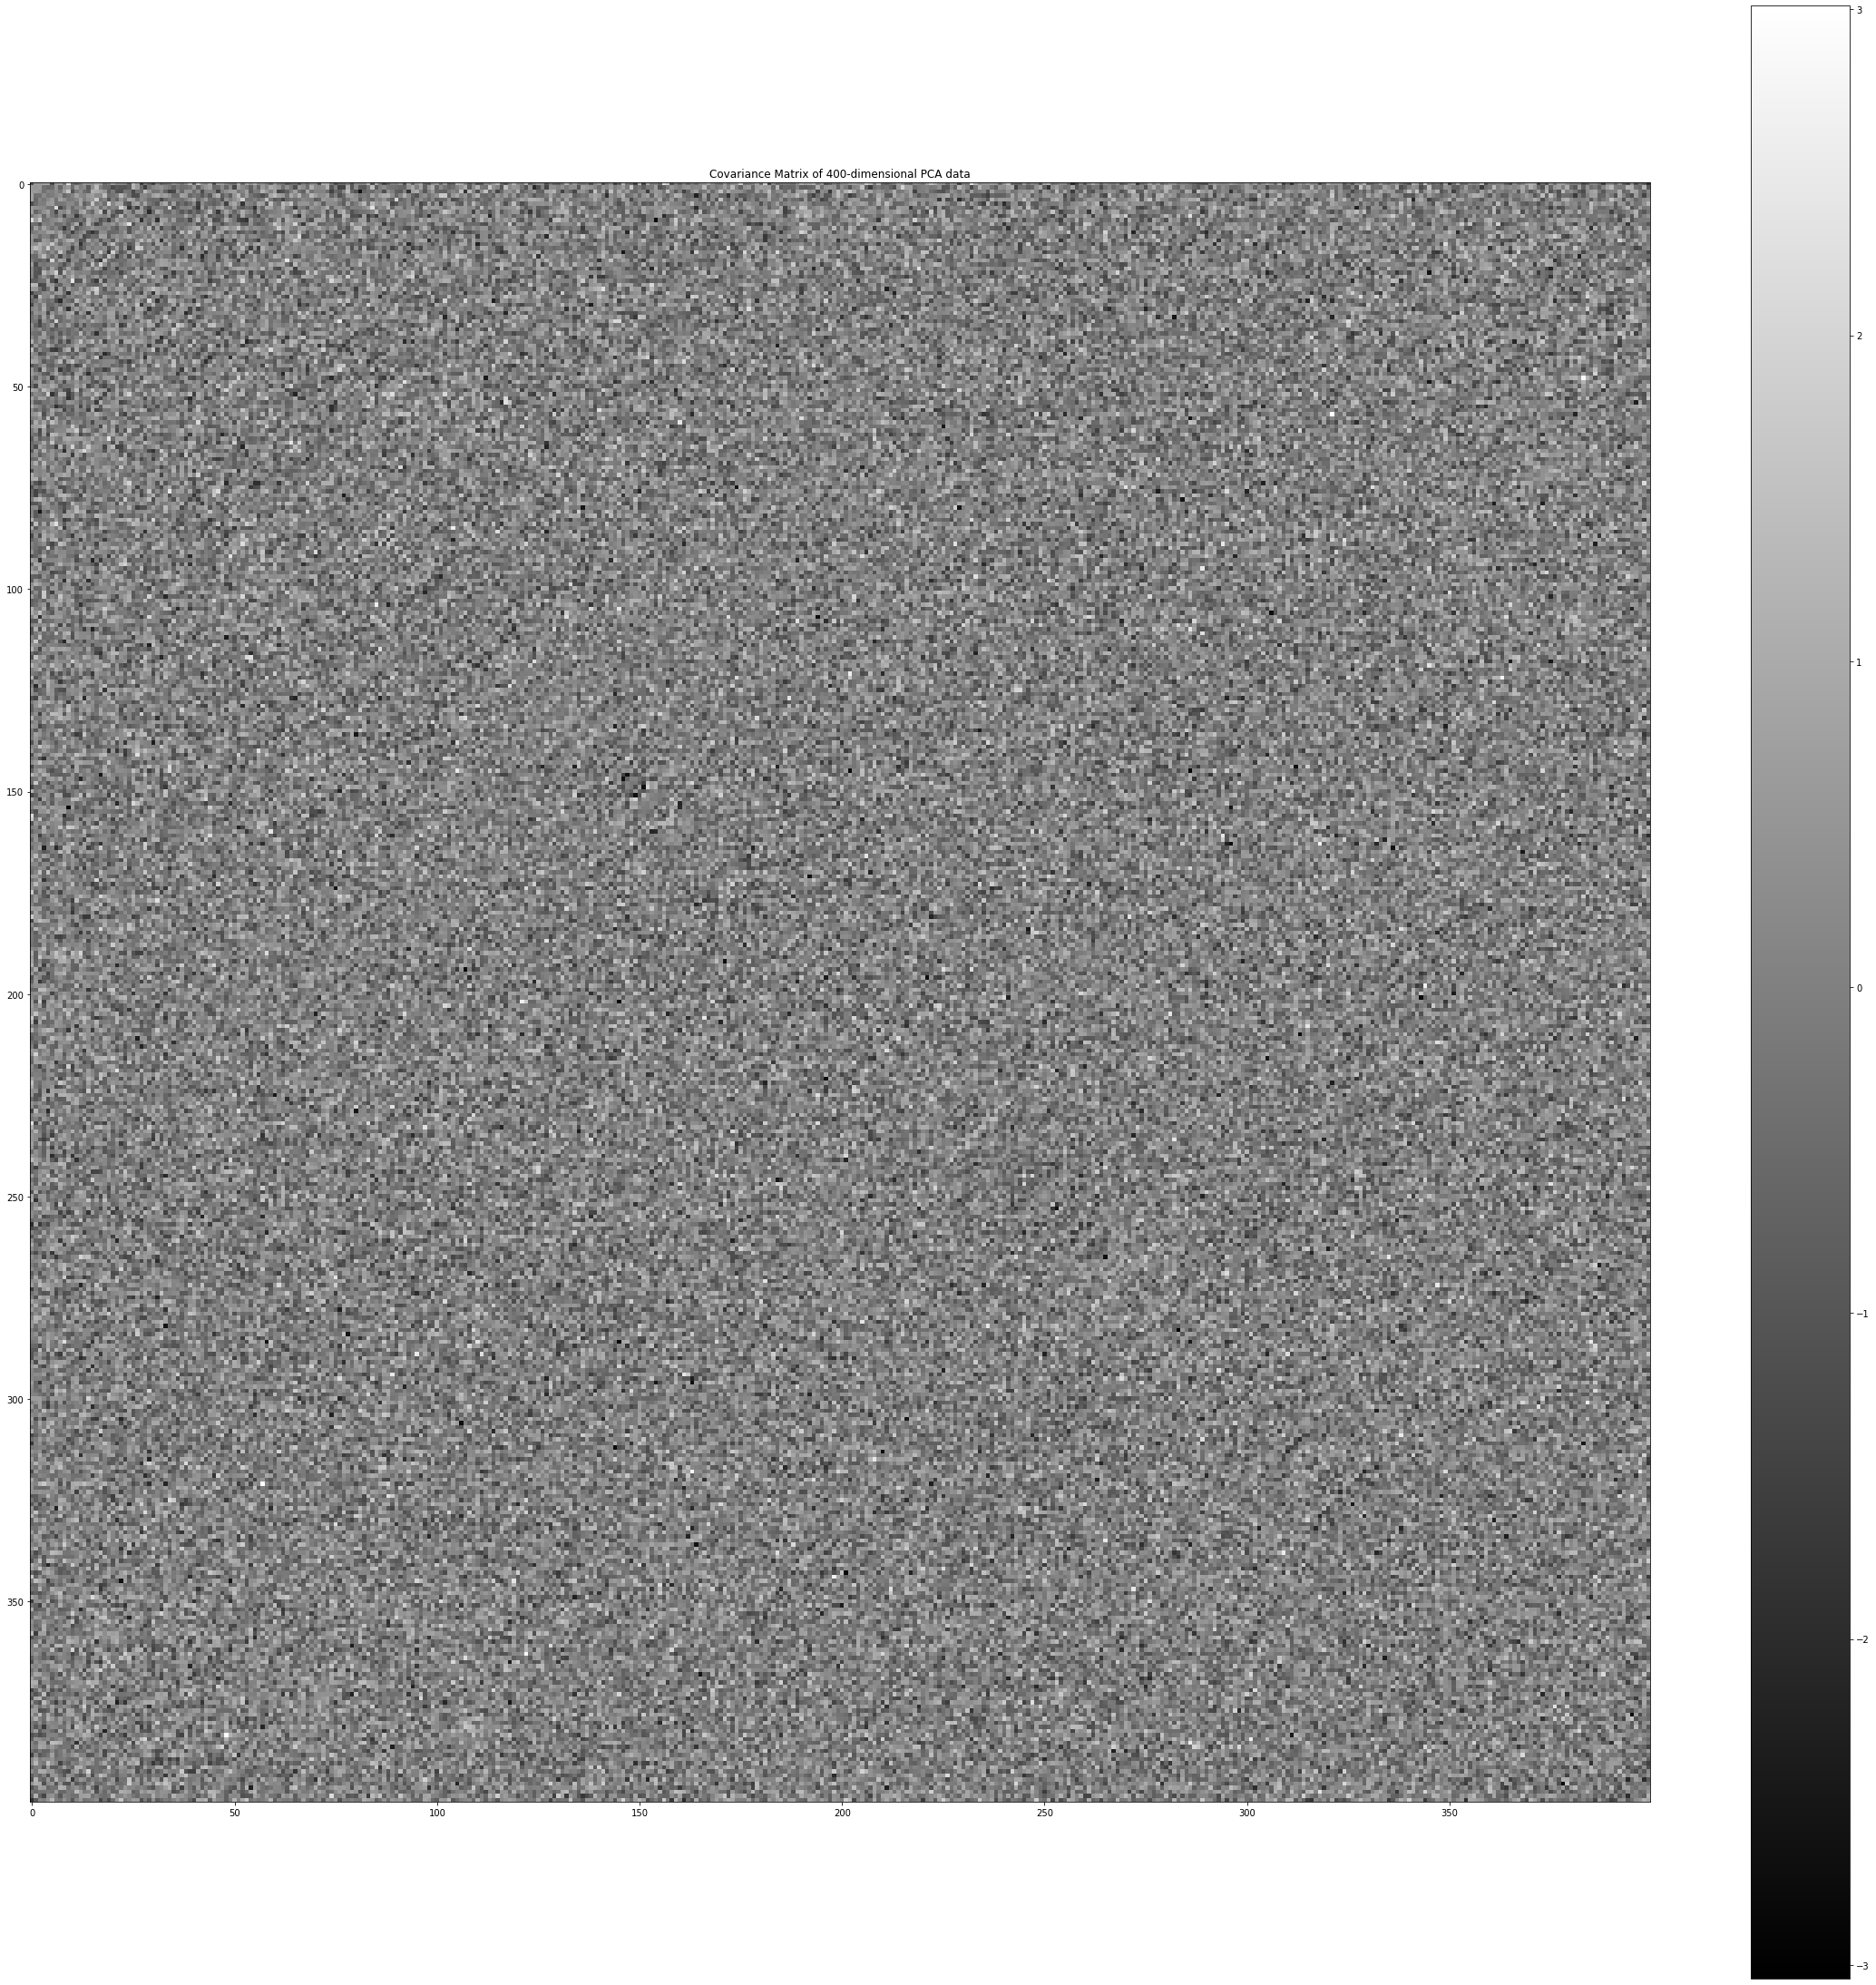

In [22]:
tmp_400 = I_minus_W_400.cpu().detach().numpy()
plt.figure(figsize=(40, 40))
plt.title("Covariance Matrix of 400-dimensional PCA data")
plt.imshow((tmp_400 + tmp_400.T) / 2, cmap='gray')
plt.colorbar()
plt.show()